# Unbalanced Neural Dual Solver

This tutorial shows how to use `OTT` to compute the Wasserstein-2 optimal transport map between continuous measures in Euclidean space in an unbalanced manner.
{class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solves this
problem by optimizing parameterized Kantorovich dual potential functions
and returning a  {class}`~ott.problems.linear.potentials.DualPotentials`
object that can be used to transport unseen source data samples to its target distribution (or vice-versa) or compute the corresponding distance between new source and target distribution.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [14]:
from dataclasses import dataclass
from functools import partial

from IPython.display import clear_output, display

import jax
import jax.numpy as jnp
import numpy as np
import optax
#from torch.utils.data import DataLoader, IterableDataset

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.problems.linear import potentials
from ott.solvers.linear import sinkhorn
from ott.problems.linear.linear_problem import LinearProblem
from ott.problems.nn import dataset
from ott.solvers.nn import models, neuraldual
from ott.tools import plot, sinkhorn_divergence

## Setup Training and Validation Datasets

We apply the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` to compute the transport between toy datasets.

Here, our data is "unbalanced", in effect the mixture components are imbalanced.


## Solve Neural Dual in an unbalanced manner

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators* that provide samples of batches from the source and target measures.

In [20]:
num_samples_visualize = 400
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = dataset.create_uniform_mixture_samplers(
    name_source="bottom",
    name_target="top",
    mixture_weights_source=[0.7, 0.3],
    mixture_weights_target=[0.3, 0.7],
    valid_batch_size=num_samples_visualize,
)

In the following, we visualize what we refer to with `unbalanced data`. In effect, the `mixture_weights_source` determines the concentration of the mass in the bottom left and the bottom right corner, respectively. If the both the first entry of `mixture_weights_source` and the second entry of `mixture_weights_target` is larger than 0.5, we will have to map across the diagonal from the bottom left to the top right to satisfy the marginal conditions. 

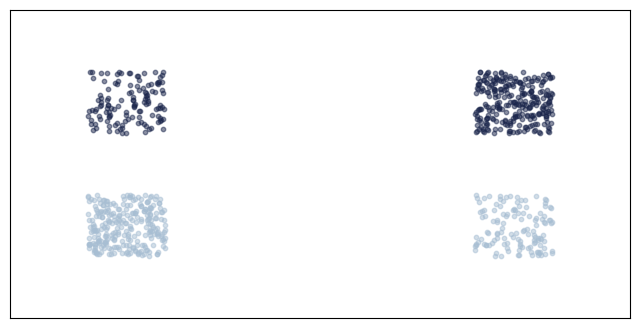

In [21]:
def plot_samples(eval_data_source, eval_data_target):
    fig, axs = plt.subplots(
        1, 1, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs.scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
    )
    axs.scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
    )
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_xlim(-1, 7)
    axs.set_ylim(-1, 4)
    

# Sample a batch for evaluation and plot it
eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

plot_samples(eval_data_source, eval_data_target)

# Discrete Optimal Transport

We start with solving the OT problem in a discrete manner

In [22]:
geom = pointcloud.PointCloud(
        eval_data_source,
        eval_data_target,
        epsilon=1e-2,
        scale_cost="mean")
prob = LinearProblem(geom, tau_a=1.0, tau_b=1.0)
out = sinkhorn.Sinkhorn()(prob)

In [39]:
tmap_flattened = out.matrix.flatten()
rng = jax.random.PRNGKey(0)
pairs = jax.random.choice(rng, len(tmap_flattened), p=tmap_flattened, shape=[100])


In [40]:
n_cols = geom.shape[1]
pairs_source = [int(pair//n_cols) for pair in pairs]
pairs_target = [int(pair%n_cols) for pair in pairs]

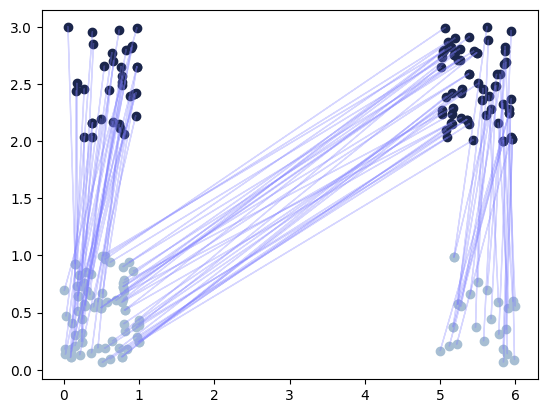

In [52]:
fig = plt.figure(facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(
    eval_data_source[pairs_source,:][:, 0],
    eval_data_source[pairs_source,:][:, 1],
    color="#A7BED3",
    label='source',
)
ax.scatter(
    eval_data_target[pairs_target,:][:, 0],
    eval_data_target[pairs_target,:][:, 1],
    color="#1A254B",
    label='target',
)


for i in range(len(pairs_source)):
    ax.arrow(
      eval_data_source[pairs_source,:][i, 0],
      eval_data_source[pairs_source,:][i, 1],
      eval_data_target[pairs_target,:][i, 0] - eval_data_source[pairs_source,:][i, 0],
      eval_data_target[pairs_target,:][i, 1] - eval_data_source[pairs_source,:][i, 1],
      color=[0.5, 0.5, 1],
      alpha=0.3
    )

Now we solve the same problem in an unbalanced manner, to get rid of the diagonal.

In [54]:
geom = pointcloud.PointCloud(
        eval_data_source,
        eval_data_target,
        epsilon=1e-2,
        scale_cost="mean")
prob = LinearProblem(geom, tau_a=0.6, tau_b=0.6)
out = sinkhorn.Sinkhorn()(prob)

In [55]:
tmap_flattened = out.matrix.flatten()
rng = jax.random.PRNGKey(0)
pairs = jax.random.choice(rng, len(tmap_flattened), p=tmap_flattened, shape=[100])


In [56]:
n_cols = geom.shape[1]
pairs_source = [int(pair//n_cols) for pair in pairs]
pairs_target = [int(pair%n_cols) for pair in pairs]

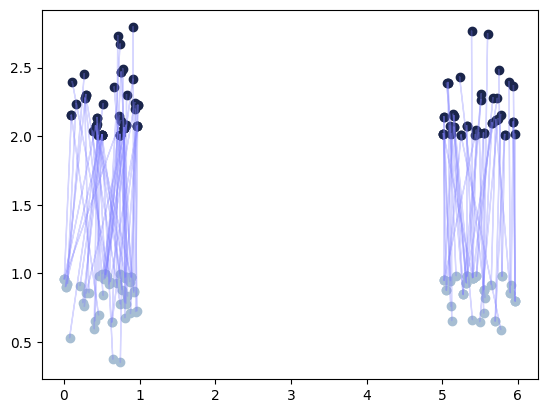

In [57]:
fig = plt.figure(facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(
    eval_data_source[pairs_source,:][:, 0],
    eval_data_source[pairs_source,:][:, 1],
    color="#A7BED3",
    label='source',
)
ax.scatter(
    eval_data_target[pairs_target,:][:, 0],
    eval_data_target[pairs_target,:][:, 1],
    color="#1A254B",
    label='target',
)


for i in range(len(pairs_source)):
    ax.arrow(
      eval_data_source[pairs_source,:][i, 0],
      eval_data_source[pairs_source,:][i, 1],
      eval_data_target[pairs_target,:][i, 0] - eval_data_source[pairs_source,:][i, 0],
      eval_data_target[pairs_target,:][i, 1] - eval_data_source[pairs_source,:][i, 1],
      color=[0.5, 0.5, 1],
      alpha=0.3
    )

## Neural Optimal Transport

First, we solve the problem in a balanced way. For the sake of demonstration we use a slightly different archtiecture than in :ref:<other notebook>. In effect, we parameterize both $f$ and $g$ with {class}`~ott.solvers.nn.models.ICNN` as suggested in {cite}`makkuva:20`. Moreover, we set `pos_weights` to `True` in {class}`~ott.solvers.nn.models.ICNN` and {class}`~ott.solvers.nn.neuraldual.W2NeuralDual`.
For more details on how to customize {class}`~ott.solvers.nn.models.ICNN`,
we refer you to the documentation.

In [6]:
# initialize models and optimizers
num_train_iters = 5001

neural_f = models.ICNN(dim_data=2, dim_hidden=[64, 64])
neural_g = models.ICNN(dim_data=2, dim_hidden=[64, 64])

optimizer_f = optax.adam(learning_rate=1e-3, b1=0.5, b2=0.9)
optimizer_g = optax.adam(learning_rate=1e-3, b1=0.5, b2=0.9)

We then initialize the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` by passing the two {class}`~ott.solvers.nn.models.ICNN` models parameterizing $f$ and $g$, as well as by specifying the input dimensions of the data and the number of training iterations to execute. Once the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` is initialized, we can obtain the neural {class}`~ott.problems.linear.potentials.DualPotentials` by passing the corresponding dataloaders to it.
For more details on how to configure the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual`, we refer you to the documentation.

With `tau_a` and `tau_b` we set the degree of unbalancedness in the left marginals and the right marginals, respectively. These, as well as `epsilon`, are used in the inner Sinkhorn loop ({cite}`eyring:22`, {cite}`luebeck:22`). More parameters for the {class}`ott.solvers.linear.sinkhorn.Sinkhorn` (as well as how to scale the cost) can be passed via `sample_sinkhorn_kwargs`.

<font color='#F2545B'>Execution of the following cell will probably take a few minutes, depending on your system and the number of training iterations.</font>

Training iteration: 650/5001


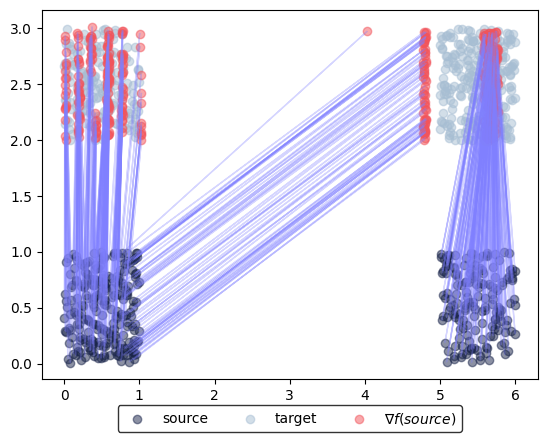

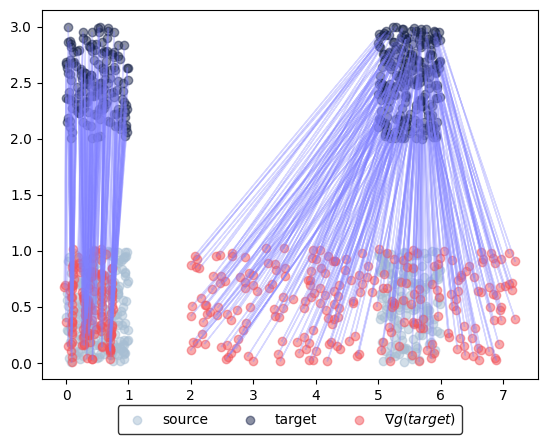

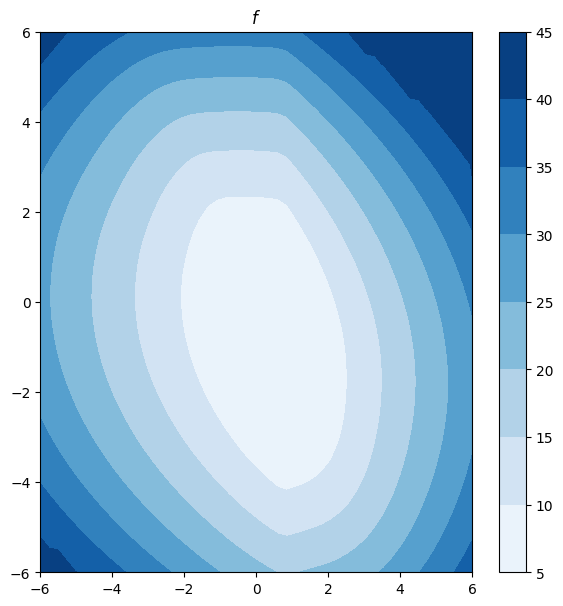

KeyboardInterrupt: 

In [9]:
def training_callback(step, learned_potentials):
    # Callback function as the training progresses to visualize the couplings.
    if step % 10 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_potential()
        display(fig)
        plt.close(fig)


neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    tau_a=0.7, 
    tau_b=0.7,
    epsilon=1,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)
clear_output()

The output of the solver, `learned_potentials`, is an instance of
{class}`~ott.problems.linear.potentials.DualPotentials`.
This  gives us access to the learned potentials and provides functions to compute and plot the forward and
inverse OT maps between the measures.

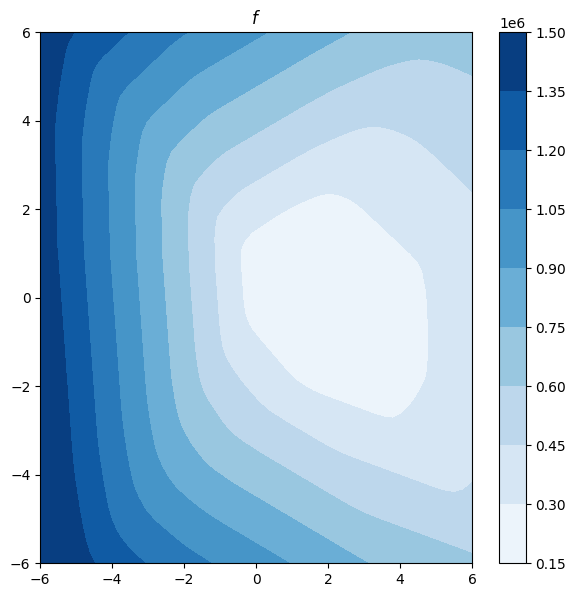

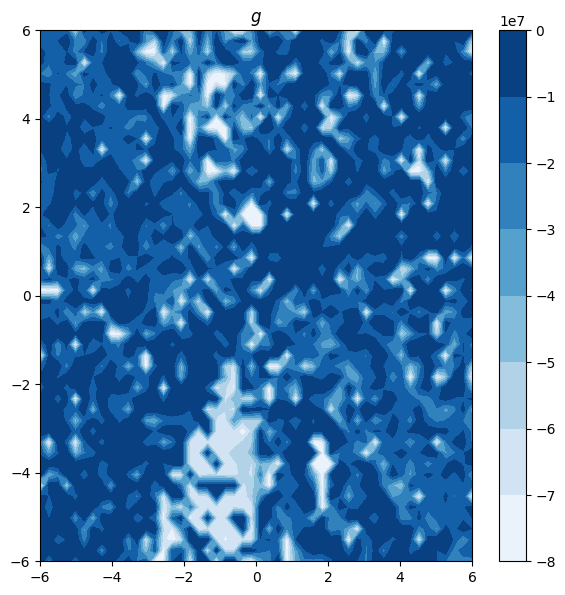

In [9]:
learned_potentials.plot_potential(forward=True)

In [ ]:
learned_potentials.plot_ot_map(
    eval_data_source,
    eval_data_target,
    forward=True,
);

In [ ]:
learned_potentials.plot_ot_map(
    eval_data_source, eval_data_target, forward=False
);

We now solve the problem in an unbalanced manner, therefore we set `tau_a` and `tau_b` to a value lower than 1. As we expect unbalancedness in both the source and the target to be of roughly the same magnitude, we set `tau_a=tau_b=0.8`. The value of `epsilon` corresponds to the regularisation parameter in the inner Sinkhorn loop, we set it to `1e-2`. 

In [15]:
def training_callback(step, learned_potentials):
    # Callback function as the training progresses to visualize the couplings.
    if step % 10 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_potential()
        display(fig)
        plt.close(fig)


neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    tau_a=0.6, 
    tau_b=0.6,
    epsilon=1e-2,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)
clear_output()

Again, we plot the potentials and the transport maps.

In [ ]:
learned_potentials.plot_potential(forward=True)

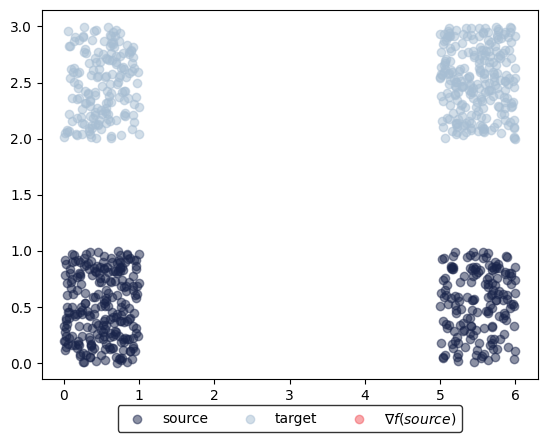

In [16]:
learned_potentials.plot_ot_map(
    eval_data_source,
    eval_data_target,
    forward=True,
);

As we can see, we now don't map across the diagonal any more, but only vertically. This is exactly analogous to the discrete case.